In [2]:
import pandas as pd
import numpy as np

import os

import matplotlib.pyplot as plt
%matplotlib inline

December 2018

I slutet av januari kommer ett nummer med tema "Ny i politiken". Till detta är det tänkt en överblick av alla de som är nya in i alla fullmäktige runt om i Sverige. Från Valmyndigheten (Henrik Hannebo) har jag fått en fil med kopplingar mellan ledamöter som valdes in förra valet och vilket id dessa har i det senaste valet. Med dessa kan jag då alltså se vilka som inte satt förra mandatperioden. Längre bak än så finns det inte några kopplingar enligt Henrik Hannebo – ansvarig handläggare på Valmyndigheten.

[Här finner man artikeln på alla nya kandidater.](https://dagenssamhalle.se/nyhet/kommunpolitikerna-parti-parti-25593)

[Och här på alla kandidaternas yrken, parti för parti.](https://dagenssamhalle.se/nyhet/har-ar-politikernas-vanligaste-yrken-26127)

## De nya kandidaterna

In [3]:
df = pd.read_excel('data/alla_valda_2018.xlsx')

In [4]:
df.columns= df.columns.str.lower().str.replace(" ","_")

In [5]:
df = df[['valtyp',
         'län',
         'kommun',
         'partiförkortning',
         'kandnr',
         'ålder_valdag',
         'kön',
         'förnamn',
         'efternamn']].rename(columns={'kandnr':'id',
                                       'ålder_valdag':'ålder',
                                       'partiförkortning':'parti'})

In [6]:
df.head()

,valtyp,län,kommun,parti,id,ålder,kön,förnamn,efternamn
0,R,NaN,NaN,M,215984.0,51.0,K,Annicka,Engblom
1,R,NaN,NaN,S,139330.0,45.0,K,Heléne,Björklund
2,R,NaN,NaN,S,139331.0,37.0,M,Magnus,Manhammar
3,R,NaN,NaN,SD,386660.0,28.0,K,Angelika,Bengtsson
4,R,NaN,NaN,SD,386652.0,49.0,M,Richard,Jomshof


In [7]:
nummer = pd.read_excel('data/kandnr_2014_2018.xlsx').rename(columns={'KANDNR2014':'kand2014','KANDNR2018':'id'})

In [8]:
nummer['kand2014'] = 'ja'

In [9]:
df = df.merge(nummer,on='id',how='outer')

In [10]:
df.kand2014.isnull().value_counts()

False    33299
True      3500
Name: kand2014, dtype: int64

Nu plockar vi fram endast de som är nya in i fullmäktige:

In [11]:
df.loc[(df['kand2014'].isnull())&(df['valtyp']=='R')].parti.value_counts()

SD    8
V     4
MP    3
M     2
KD    2
L     2
S     1
C     1
Name: parti, dtype: int64

Här ser vi ett problem med datat! T ex så fick C 9 nya mandat i riksdagen, SD fick 13. Men detta syns inte i ovan sammanställning.

I de kopplingar som Valmyndigheten så ingick inte info om vilken fullmäktige som ledamöterna satt i under förra mandatperioden. För att veta med säkerhet så måste vi först koppla varje ledamot till vilken plats de satt på under förra mandatperioden.

In [12]:
df2014 = pd.read_excel('data/alla_valda_2014.xls')\
        [['valtyp',
         'län',
         'kommun',
         'parti',
         'kandidatnr',
         'ålder',
         'kön',
         'förnamn',
         'efternamn']].rename(columns={'kandidatnr':'id2014'})

In [13]:
nummer = pd.read_excel('data/kandnr_2014_2018.xlsx').rename(columns={'KANDNR2014':'id2014','KANDNR2018':'id'})

In [14]:
df2014=df2014.merge(nummer, on='id2014',how='left')[['valtyp','parti','id2014','id']].dropna()

In [15]:
kandr2014 = df2014.groupby(['id2014','valtyp','parti']).count().reset_index().pivot(index='id2014',columns='valtyp',values='id')

In [16]:
kandr2014.columns = [x + '2014' for x in kandr2014.columns]

In [17]:
kandr2014.reset_index(inplace=True)

In [18]:
kandr2014 = kandr2014.merge(nummer,on='id2014',how='left')

In [19]:
df = pd.read_excel('data/alla_valda_2018.xlsx')

In [20]:
df.columns= df.columns.str.lower().str.replace(" ","_")

In [21]:
df = df[['valtyp',
         'län',
         'kommun',
         'partiförkortning',
         'kandnr',
         'ålder_valdag',
         'kön',
         'förnamn',
         'efternamn']].rename(columns={'kandnr':'id',
                                       'ålder_valdag':'ålder',
                                       'partiförkortning':'parti'})

In [22]:
kandr2018 = df.groupby(['id','valtyp','parti']).count().reset_index().pivot(index='id',columns='valtyp',values='efternamn').reset_index()

In [23]:
kandr2018 = kandr2018.merge(kandr2014,on='id',how='left').drop('id2014',axis=1).set_index('id')

In [24]:
for col in ['K','L','R']:
    kandr2018.loc[kandr2018[col]==kandr2018[f'{col}2014'],f'{col}2014'] = col
    kandr2018.loc[kandr2018[f'{col}2014']!=col,f'{col}2014'] = np.nan

In [25]:
kandr2018 = kandr2018.iloc[:,3:].reset_index()

In [26]:
df = df.merge(kandr2018,on='id',how='left')

In [27]:
for elec in ['K','L','R']:
    df.loc[df['valtyp']==df[f'{elec}2014'],'samma_stol'] = 'ja'

In [28]:
df.loc[(df['valtyp']=='R')&(df['samma_stol'].isnull()),'parti'].value_counts()

S     32
SD    29
M     26
KD    13
V     13
C     12
MP     9
L      7
Name: parti, dtype: int64

In [29]:
df.columns

Index(['valtyp', 'län', 'kommun', 'parti', 'id', 'ålder', 'kön', 'förnamn',
       'efternamn', 'K2014', 'L2014', 'R2014', 'samma_stol'],
      dtype='object')

In [30]:
test = df['K2014'].apply(lambda x: [x] if x else None) + df['L2014'].apply(lambda x: [x] if x else None) + df['R2014'].apply(lambda x: [x] if x else None)

In [31]:
df['stolar2014'] = test.apply(lambda x: pd.Series(x).dropna().tolist())

In [32]:
df = df.drop(['K2014', 'L2014', 'R2014'],axis=1)

In [33]:
df.loc[(df['samma_stol'].isnull())&(df['stolar2014'].apply(lambda x: len(x))>0),'samma_stol'] = 'annan'

In [34]:
df.samma_stol = df.samma_stol.fillna('satt ej 2014')

In [35]:
partier = ['M','C','L','KD','S','V','MP','SD']

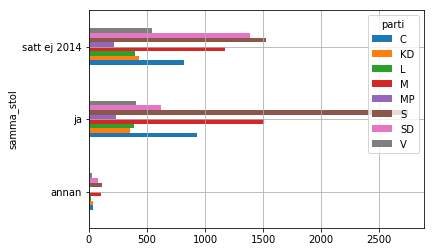

In [36]:
df.loc[df['parti'].isin(partier)].groupby(['parti','samma_stol']).count()['valtyp'].sort_values().unstack(0).plot(kind='barh',grid=True)

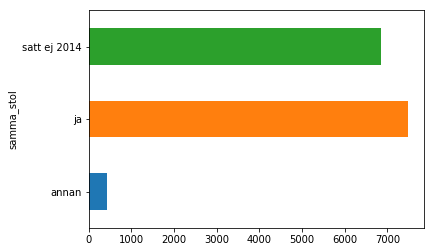

In [37]:
df.groupby('samma_stol').count()['valtyp'].plot(kind='barh')

In [38]:
df.head()

,valtyp,län,kommun,parti,id,ålder,kön,förnamn,efternamn,samma_stol,stolar2014
0,R,NaN,NaN,M,215984.0,51.0,K,Annicka,Engblom,ja,[R]
1,R,NaN,NaN,S,139330.0,45.0,K,Heléne,Björklund,annan,[K]
2,R,NaN,NaN,S,139331.0,37.0,M,Magnus,Manhammar,ja,[R]
3,R,NaN,NaN,SD,386660.0,28.0,K,Angelika,Bengtsson,ja,[R]
4,R,NaN,NaN,SD,386652.0,49.0,M,Richard,Jomshof,ja,[R]


## Yrken

In [39]:
yrken = pd.read_csv('data/yrken_alla_kand_tvättad.csv')

In [40]:
yrken = yrken.loc[~(yrken['tvätt2']=='ort')]

In [41]:
df.shape

(14745, 11)

In [42]:
os.makedirs('res')

In [43]:
df.merge(yrken,on='id',how='left').to_excel('res/med_valsedelsuppgift.xlsx',index=False)

In [44]:
slutv = df.merge(yrken.drop('valsedelsuppgift',axis=1).drop_duplicates(),
         on='id',
         how='left')\
    .drop('tvätt',axis=1)\
    #.rename(columns={'tvätt2':'yrke'})#.drop_duplicates()
    #.to_excel('resultat/med_valsedelsuppgift.xlsx',index=False)

In [45]:
slutv = slutv.rename(columns={'tvätt2':'yrke'})#.drop_duplicates()

In [46]:
slutv.stolar2014 = slutv.stolar2014.apply(lambda x: ','.join(x))

In [47]:
slutv.drop_duplicates().to_excel('res/utan_valsedelsuppgift.xlsx',index=False)

In [48]:
slutv.drop_duplicates().shape

(15373, 12)

In [49]:
df.to_excel('res/utan_yrken.xlsx',index=False)

In [50]:
slutv.yrke.isnull().value_counts()

False    10883
True      4588
Name: yrke, dtype: int64

In [51]:
slutv.yrke.value_counts().reset_index().rename(columns={'index':'yrke','yrke':'antal'}).to_excel('res/topplista_yrken.xlsx',index=False)

In [52]:
tmp = slutv.yrke.value_counts().reset_index().rename(columns={'index':'yrke','yrke':'antal'})

In [53]:
tmp.loc[tmp['antal']>0].shape#.sum()

(775, 2)

In [54]:
slutv.yrke.value_counts().iloc[:244].sum()

9923

In [55]:
slutv.yrke.value_counts().sum()

10883

In [56]:
10330/10883

0.9491868051088854